In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import concurrent
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from concurrent.futures import ThreadPoolExecutor
from IPython.core.display import display, HTML

warnings.filterwarnings("ignore")

In [2]:
# df = None

# def read_csv(url):
#     return pd.read_csv(url, dtype={
#         "CRS_DEP_TIME": str,
#         "DEP_TIME": str,
#         "CRS_ARR_TIME": str,
#         "MONTH": str,
#         "DAY_OF_MONTH": str,
#         "DAY_OF_WEEK": str,
#     })

# with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#     future_list = []

#     for index in range(1, 13):
#         future = executor.submit(read_csv, f"datasets/airline_arrival_delay/month{index}.csv")
#         future_list.append(future)

#     for future in future_list:
#         try:
#             result = future.result(timeout=20)
#             if df is None:
#                 df = result
#             else:
#                 df = df.append(result)
#         except Exception as e:
#             print("Cannot load", e)

In [3]:
# load dataset
use_columns = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "UniqueCarrier",
    "FlightNum",
    "TailNum",
    "CRSElapsedTime",
    "ArrDelay",
    "Origin",
    "Dest",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "Cancelled",
    "Diverted",
]

df = pd.read_csv("datasets/airline_arrival_delay/2007_light.csv", dtype={
    "Month": str,
    "DayofMonth": str,
    "DayOfWeek": str,
    "DepTime": str,
    "CRSDepTime": str,
    "CRSArrTime": str,
    "FlightNum": str,
    "Diverted": str
}, usecols=use_columns)

def add_prefix(columns, prefix, additional_text=""):
    new_columns = []
    
    for col in columns:
        transform = ''.join([e.capitalize() for e in col.split('_')])
        
        if prefix.lower() == col.lower():
            new_columns.append(f"{prefix}{additional_text}")
        else:
            new_columns.append(f"{prefix}{additional_text}{transform}")
            
    return new_columns

df_carriers = pd.read_csv("datasets/airline_arrival_delay/carriers.csv")
df_carriers.columns = add_prefix(df_carriers.columns, "Carrier")

df_planes = pd.read_csv("datasets/airline_arrival_delay/plane-data.csv")
df_planes.columns = add_prefix(df_planes.columns, "Plane")

df_airports_from = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_from.columns = add_prefix(df_airports_from.columns, "Airport", "From")

df_airports_to = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_to.columns = add_prefix(df_airports_to.columns, "Airport", "To")

In [4]:
df = pd.merge(df, df_carriers, left_on="UniqueCarrier", right_on="CarrierCode", how="inner")
df = pd.merge(df, df_planes, left_on="TailNum", right_on="PlaneTailnum", how="inner")
df = pd.merge(df, df_airports_from, left_on="Origin", right_on="AirportFromIata", how="inner")
df = pd.merge(df, df_airports_to, left_on="Dest", right_on="AirportToIata", how="inner")

In [5]:
del df_carriers, df_planes, df_airports_from, df_airports_to

In [6]:
df = df.sample(n=3000000)

## All columns and their description

2. Month: ~~ 1-12
3. DayofMonth: ~~ 1-31
4. DayOfWeek: ~~ 1 (Monday) - 7 (Sunday)
5. CRSDepTime: ~~ scheduled departure time (local, hhmm)
6. CRSArrTime: ~~ scheduled arrival time (local, hhmm)
7. UniqueCarrier: ~~ unique carrier code
8. FlightNum: ~~ flight number
9. TailNum: ~~ plane tail number
10. CRSElapsedTime: ~~ in minutes ------ __have negative number__
11. ArrDelay: ~~ arrival delay, in minutes
12. Origin: ~~ origin IATA airport code
13. Dest: ~~ destination IATA airport code
14. Distance: ~~ in miles
15. TaxiIn: ~~ taxi in time, in minutes
16. TaxiOut: ~~ taxi out time in minutes
17. Cancelled: ~~ was the flight cancelled?
18. Diverted: ~~ 1 = yes, 0 = no

## Exploratory Data Analysis

In [7]:
# set labels for dataset
df["IsLate"] = df["ArrDelay"].apply(lambda x: x > 30)
# filter out cancelled flights
df = df[df["Cancelled"] == False]

# drop unnecessary columns
df = df.drop([
    "UniqueCarrier",
    "CarrierCode",
    "TailNum",
    "PlaneTailnum",
    "Origin",
    "AirportFromIata",
    "Dest",
    "AirportToIata",
    "ArrDelay",
    "Cancelled",
    "AirportFromCountry",
    "AirportToCountry",
], axis=1)

__CrsElapsedTime:__ Negative numbers means flying back in time zone (bay ngược múi giờ)

In [8]:
# after filtering unnecessary columns, we now have only 21 features and 1 label
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2981815 entries, 733327 to 5445013
Data columns (total 31 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Month               object 
 1   DayofMonth          object 
 2   DayOfWeek           object 
 3   CRSDepTime          object 
 4   CRSArrTime          object 
 5   FlightNum           object 
 6   CRSElapsedTime      float64
 7   Distance            int64  
 8   TaxiIn              int64  
 9   TaxiOut             int64  
 10  Diverted            object 
 11  CarrierDescription  object 
 12  PlaneType           object 
 13  PlaneManufacturer   object 
 14  PlaneIssueDate      object 
 15  PlaneModel          object 
 16  PlaneStatus         object 
 17  PlaneAircraftType   object 
 18  PlaneEngineType     object 
 19  PlaneYear           object 
 20  AirportFrom         object 
 21  AirportFromCity     object 
 22  AirportFromState    object 
 23  AirportFromLat      float64
 24  AirportFromLong    

In [9]:
df.describe()

,CRSElapsedTime,Distance,TaxiIn,TaxiOut,AirportFromLat,AirportFromLong,AirportToLat,AirportToLong
count,2.981815e+06,2.981815e+06,2.981815e+06,2.981815e+06,2.981815e+06,2.981815e+06,2.981815e+06,2.981815e+06
mean,1.290422e+02,7.360381e+02,6.814925e+00,1.666671e+01,3.673676e+01,-9.555846e+01,3.673921e+01,-9.553350e+01
std,7.159585e+01,5.717936e+02,5.110538e+00,1.177733e+01,5.756863e+00,1.838432e+01,5.753227e+00,1.837528e+01
min,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.770189e+01,-1.766460e+02,1.770189e+01,-1.766460e+02
25%,7.800000e+01,3.250000e+02,4.000000e+00,1.000000e+01,3.343417e+01,-1.119778e+02,3.343417e+01,-1.119778e+02
50%,1.100000e+02,5.880000e+02,6.000000e+00,1.400000e+01,3.750517e+01,-8.997667e+01,3.750517e+01,-8.997667e+01
75%,1.600000e+02,9.650000e+02,8.000000e+00,1.900000e+01,4.077724e+01,-8.144247e+01,4.077724e+01,-8.131603e+01
max,6.600000e+02,4.962000e+03,5.450000e+02,5.300000e+02,7.128545e+01,-6.479856e+01,7.128545e+01,-6.479856e+01


In [10]:
df.describe(include="O").T

,count,unique,top,freq
Month,2981815,12,8,267022
DayofMonth,2981815,31,19,100259
DayOfWeek,2981815,7,1,444810
CRSDepTime,2981815,1178,600,52700
CRSArrTime,2981815,1383,1930,10867
FlightNum,2981815,7564,16,2215
Diverted,2981815,2,0,2974886
CarrierDescription,2981815,19,Southwest Airlines Co.,468017
PlaneType,2828346,5,Corporation,2809121
PlaneManufacturer,2828346,35,BOEING,1168664


In [11]:
df.head(5).T

,733327,5105070,6498541,3107326,4536776
Month,1,1,12,11,3
DayofMonth,17,1,30,18,8
DayOfWeek,3,1,7,7,4
CRSDepTime,1000,1940,2020,1000,30
CRSArrTime,1144,2309,2320,1543,642
FlightNum,1742,1788,3589,1050,1198
CRSElapsedTime,104,209,120,223,252
Distance,507,1237,772,1660,2075
TaxiIn,4,6,6,10,3
TaxiOut,46,22,21,12,9


In [12]:
print(f"Total rows: {len(df)}")

Total rows: 2981815


### Check missing values

In [13]:
# list all columns with their total missing values
nan_summary = df.isnull().sum()
nan_summary

Month                      0
DayofMonth                 0
DayOfWeek                  0
CRSDepTime                 0
CRSArrTime                 0
FlightNum                  0
CRSElapsedTime             0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Diverted                   0
CarrierDescription         0
PlaneType             153469
PlaneManufacturer     153469
PlaneIssueDate        153469
PlaneModel            153469
PlaneStatus           153469
PlaneAircraftType     153469
PlaneEngineType       153469
PlaneYear             153469
AirportFrom                0
AirportFromCity         2136
AirportFromState        2136
AirportFromLat             0
AirportFromLong            0
AirportTo                  0
AirportToCity           2143
AirportToState          2143
AirportToLat               0
AirportToLong              0
IsLate                     0
dtype: int64

In [14]:
# the missing value only 5% which is not really significant => drop all missing value
df = df.dropna()

### Heatmap visualization

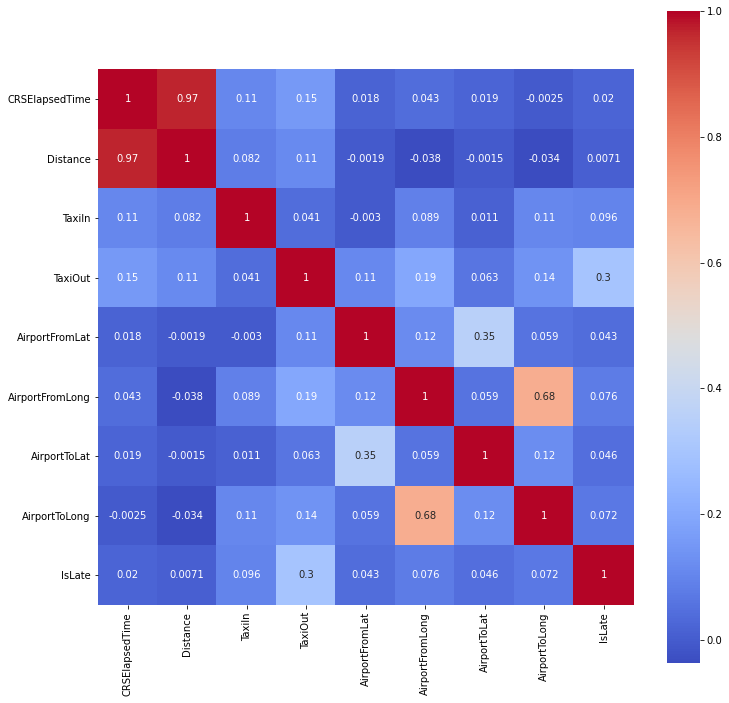

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True, cmap="coolwarm", ax=ax);

# the scheduled time & actual time is strictly correlated -> should get the difference
# airtime & distance are also correlated with actual & schedule elapsed time

### Visualization numerical data based on IsLate label

<Figure size 720x504 with 0 Axes>

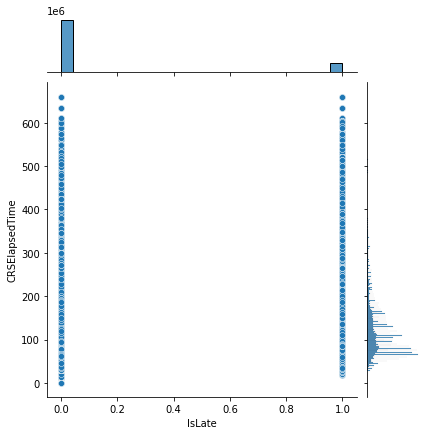

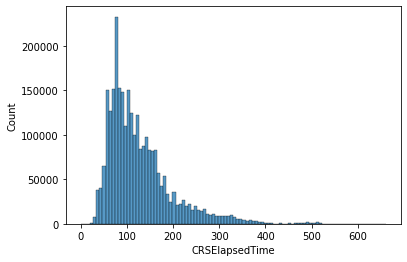

<Figure size 720x504 with 0 Axes>

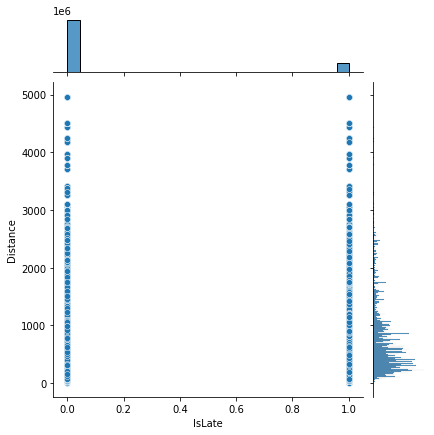

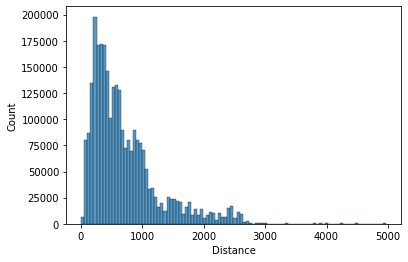

<Figure size 720x504 with 0 Axes>

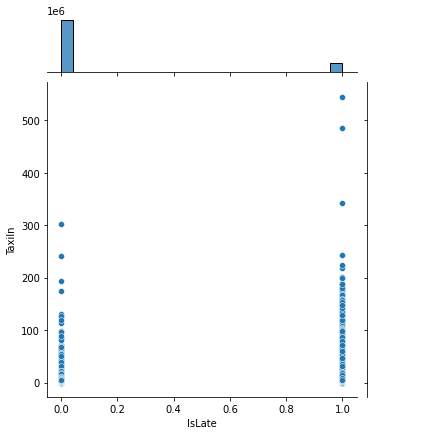

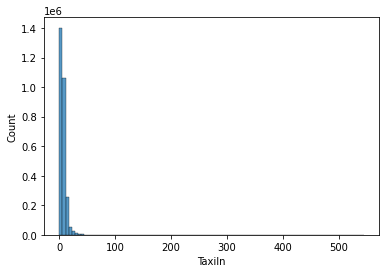

<Figure size 720x504 with 0 Axes>

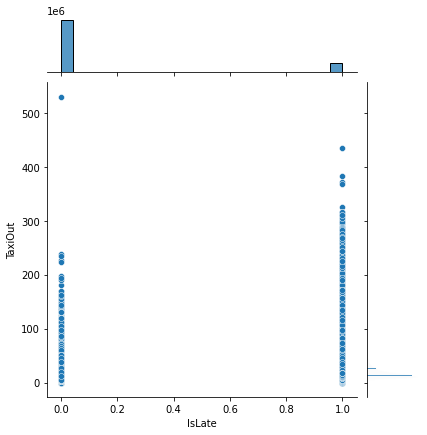

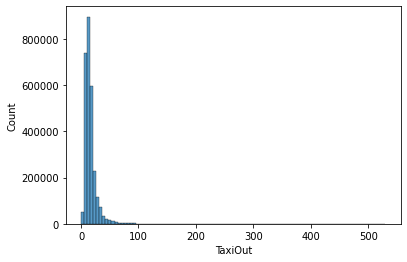

<Figure size 720x504 with 0 Axes>

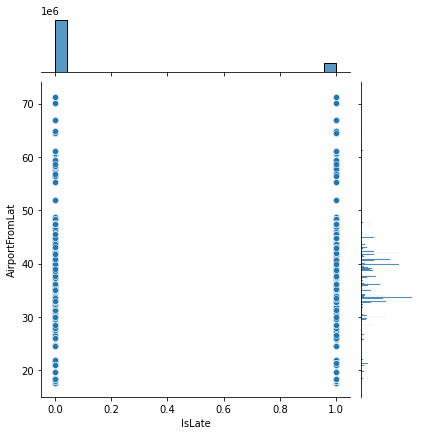

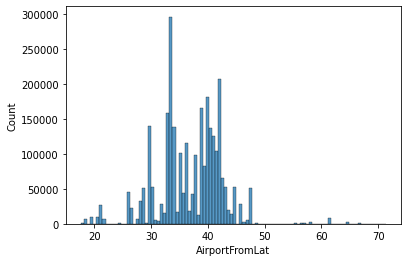

<Figure size 720x504 with 0 Axes>

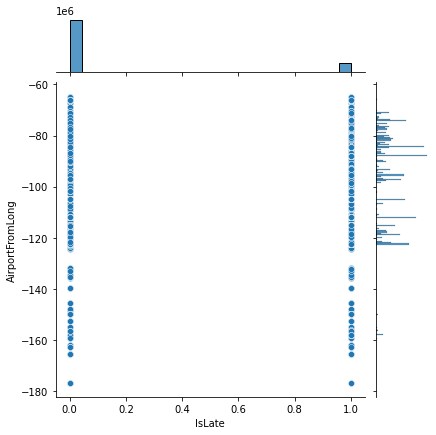

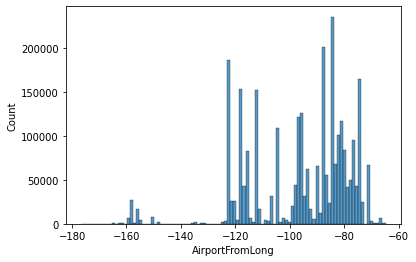

<Figure size 720x504 with 0 Axes>

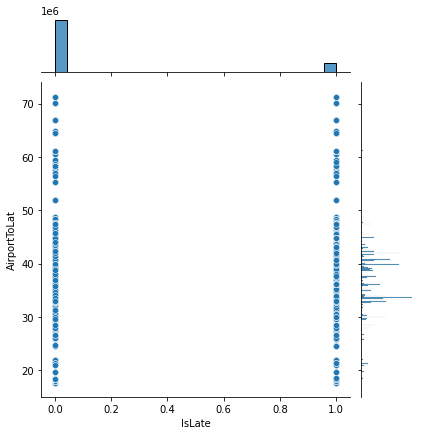

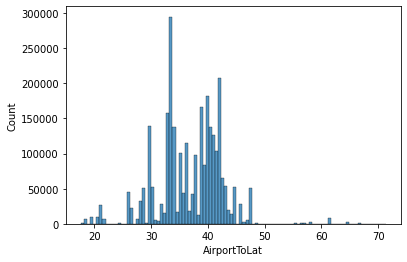

<Figure size 720x504 with 0 Axes>

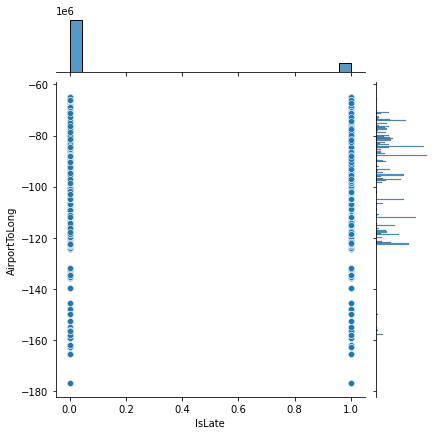

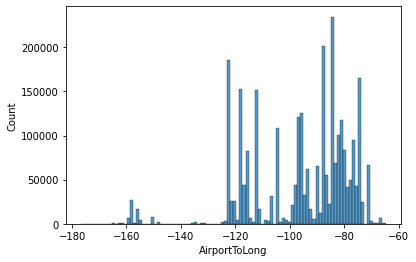

In [16]:
numerical_features = [
    "CRSElapsedTime",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "AirportFromLat",
    "AirportFromLong",
    "AirportToLat",
    "AirportToLong"
]

for column in numerical_features:
    plt.figure(figsize=(10, 7))
    display(HTML(f"<h4>{column}</h4>"))
    
    sns.jointplot(data=df, x="IsLate", y=column);
    plt.show()
    
    sns.histplot(df[column], bins=100);
    plt.show()

# Via data population, I can see that only the features like TaxiIn, Taxiout affect the lateness directly
# Significantly, distance doesn't show any relation with IsLate

### Visualization categorical data based on IsLate label

In [17]:
def split_hour(date):
    return date[:2]

def add_prefix_to_date(day):
    if len(day) == 1:
        return f"0{day}"
    
    return day

def add_prefix_to_time(time):
    return time.rjust(4, "0")

# df = df_backup.copy()
df["CRSDepTime"] = df["CRSDepTime"].apply(add_prefix_to_time)
df["CRSArrTime"] = df["CRSArrTime"].apply(add_prefix_to_time)
df["CRSDepTime_Hour"] = df["CRSDepTime"].apply(split_hour)
df["CRSArrTime_Hour"] = df["CRSArrTime"].apply(split_hour)
df["Month"] = df["Month"].apply(add_prefix_to_date)
df["DayofMonth"] = df["DayofMonth"].apply(add_prefix_to_date)
df["Diverted"] = df["Diverted"].map({"0": "Non-diverted", "1": "Diverted"})
df["PlaneIssueYear"] = df["PlaneIssueDate"].apply(lambda e: e.split("/")[-1])

# diverted is all NaN column, so I would drop this feature
df = df.drop(["CRSDepTime", "CRSArrTime", "PlaneIssueDate", "Diverted"], axis=1)

In [18]:
def calculate_categorical_percentage(df, column):
    visualize = df.groupby(column)["IsLate"].value_counts().sort_index().to_frame()
    visualize["TotalFlights"] = df.groupby(column)["IsLate"].value_counts().values
    visualize = visualize.drop(["IsLate"], axis=1).sort_index().reset_index()
    
    column_values1 = visualize[visualize["IsLate"] == True][column].unique()
    column_values2 = visualize[visualize["IsLate"] == False][column].unique()
    
    column_values = list(set(column_values1) & set(column_values2))
    column_values.sort()
    
    total_flights = visualize[visualize[column].isin(column_values)].groupby(column)["TotalFlights"].sum()
    is_late = visualize[(visualize["IsLate"] == True) & (visualize[column].isin(column_values))]["TotalFlights"]
    is_not_late = visualize[(visualize["IsLate"] == False) & (visualize[column].isin(column_values))]["TotalFlights"]

    is_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_late)]
    is_not_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_not_late)]
    
    return visualize, column_values, is_late_percentage, is_not_late_percentage

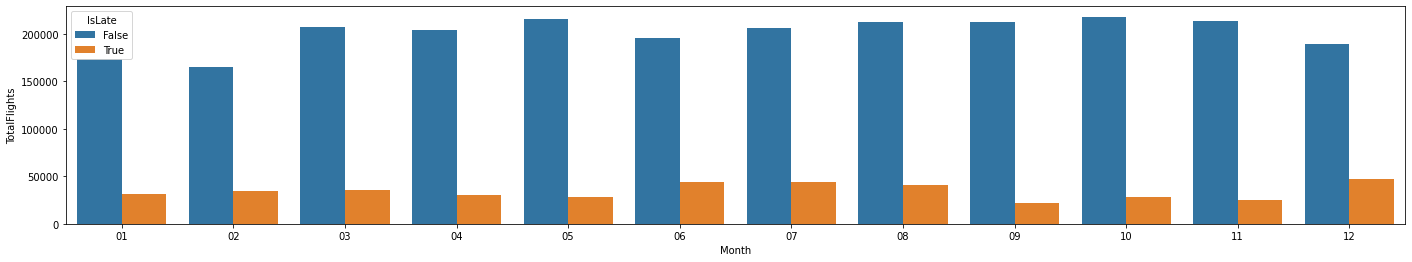

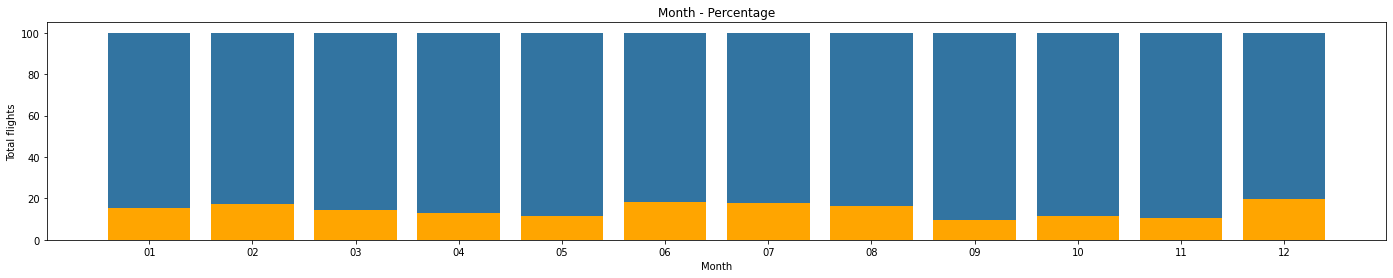

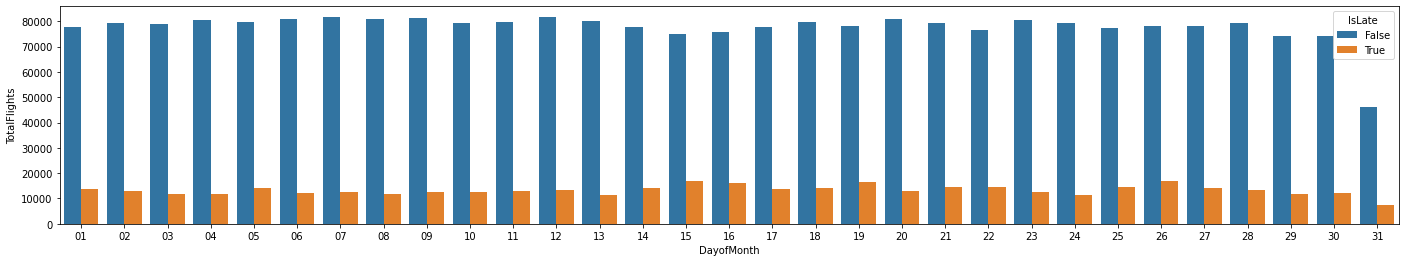

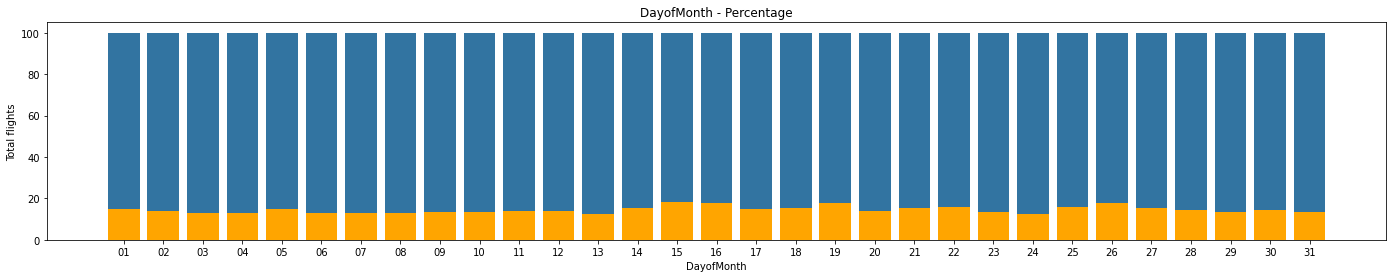

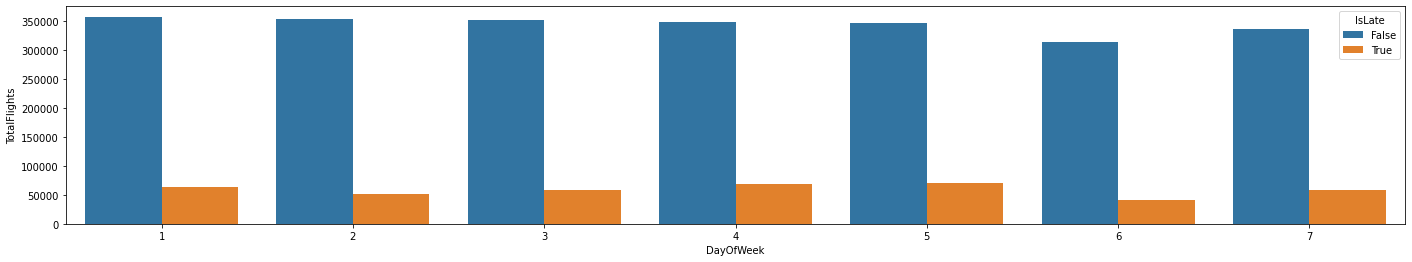

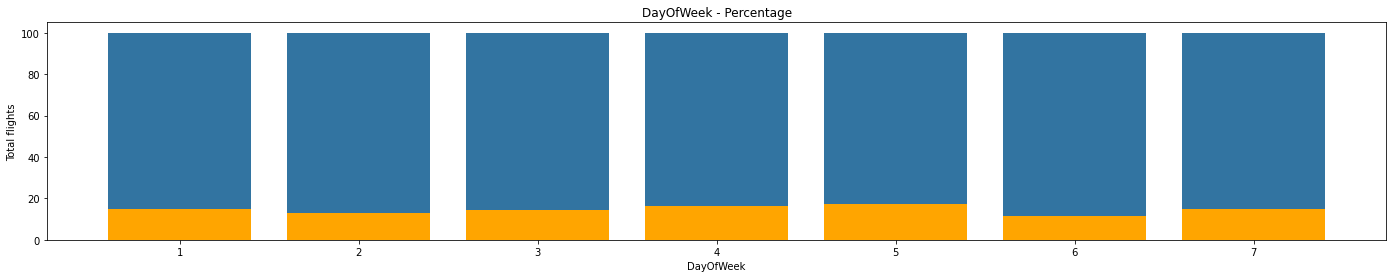

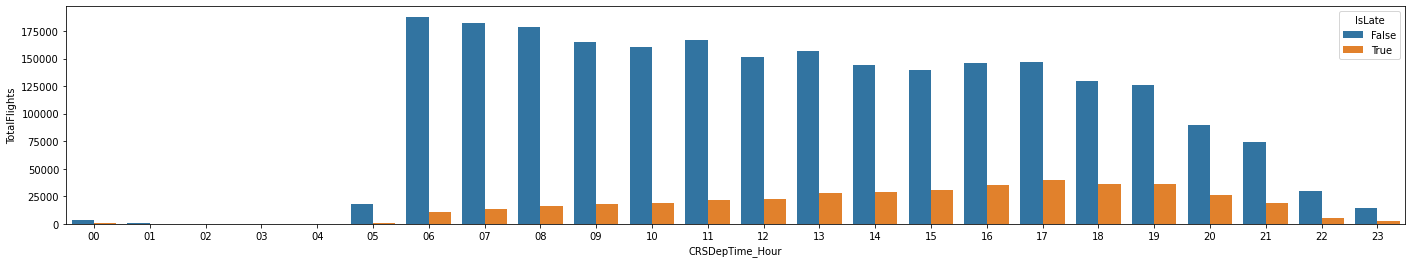

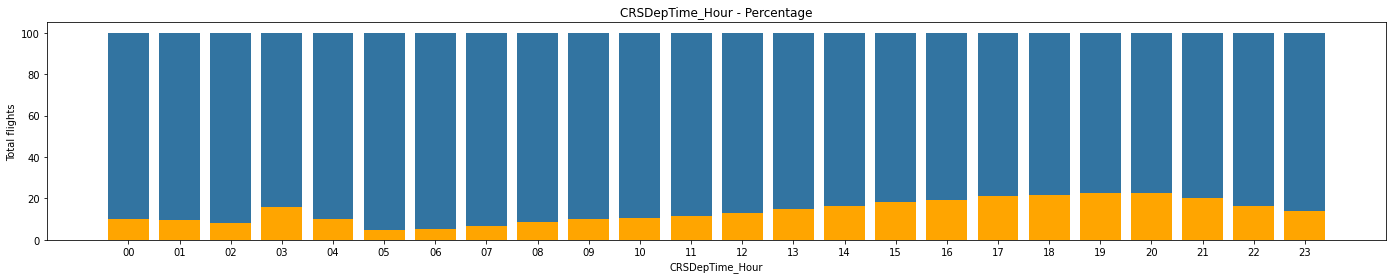

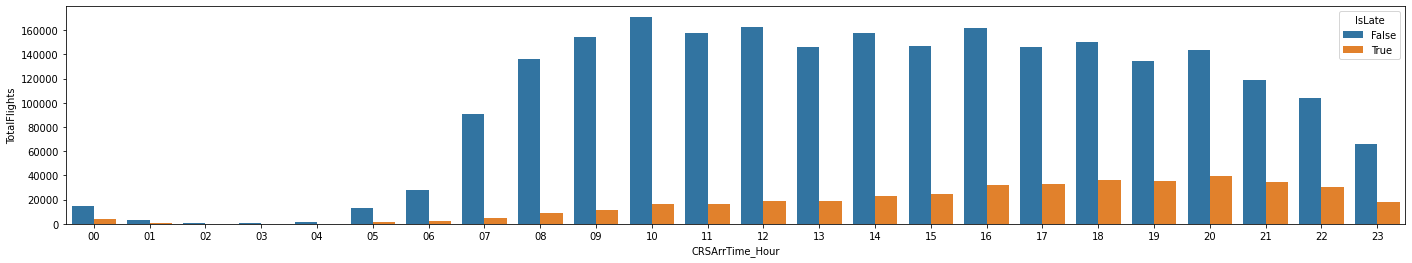

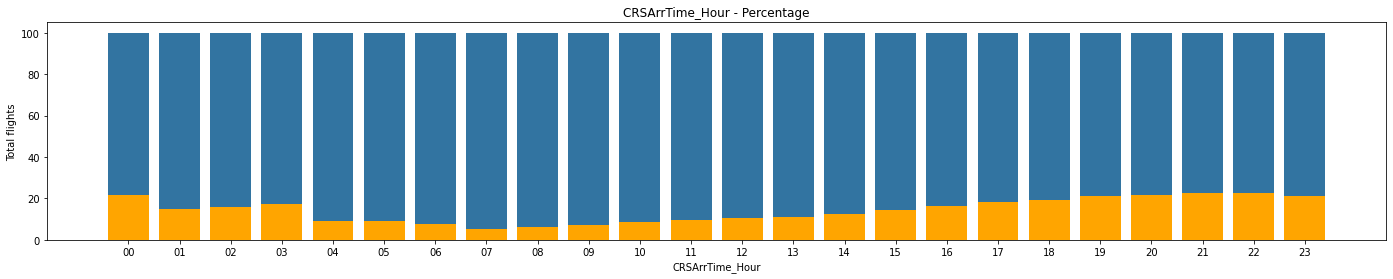

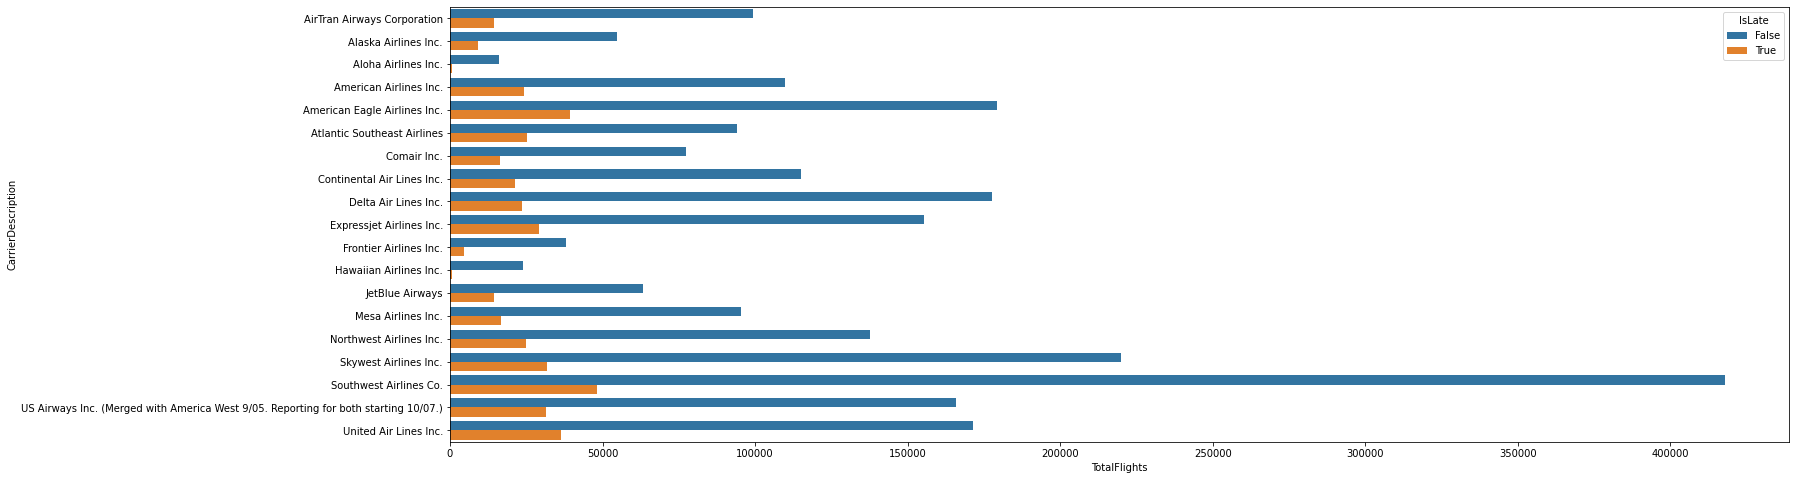

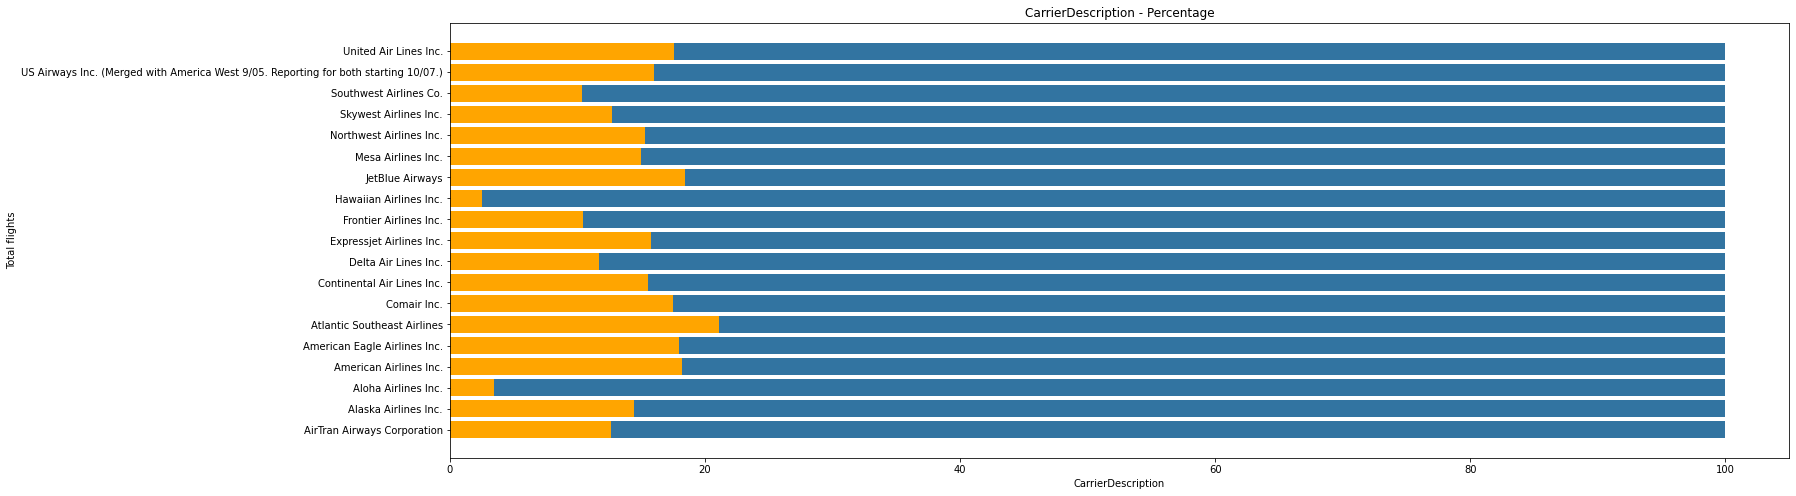

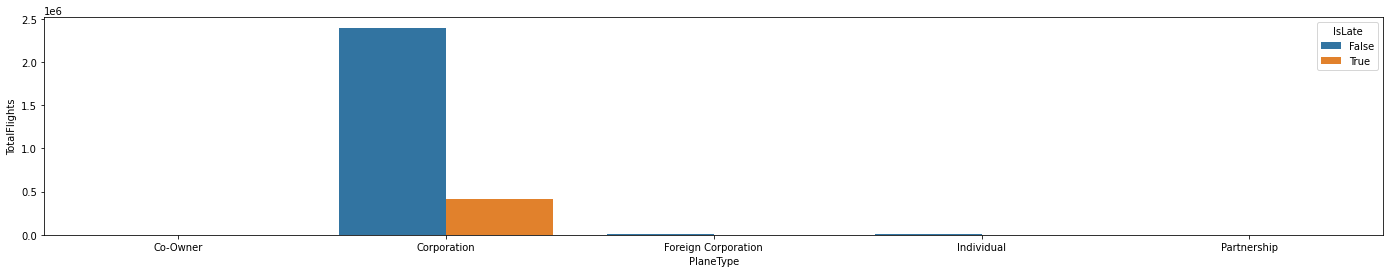

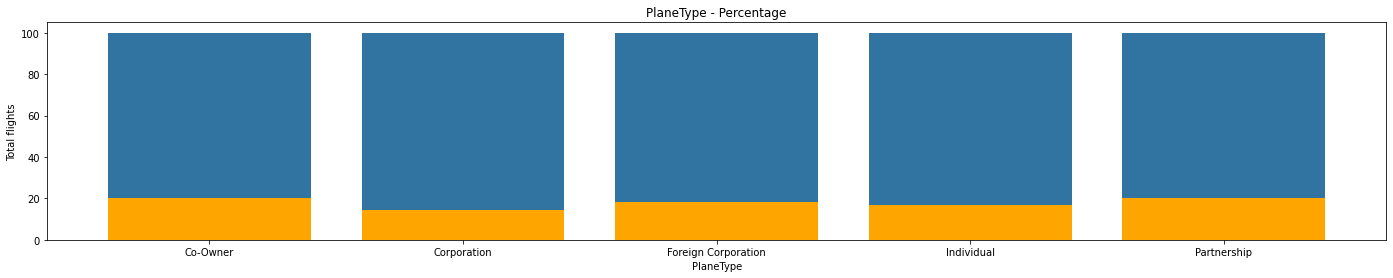

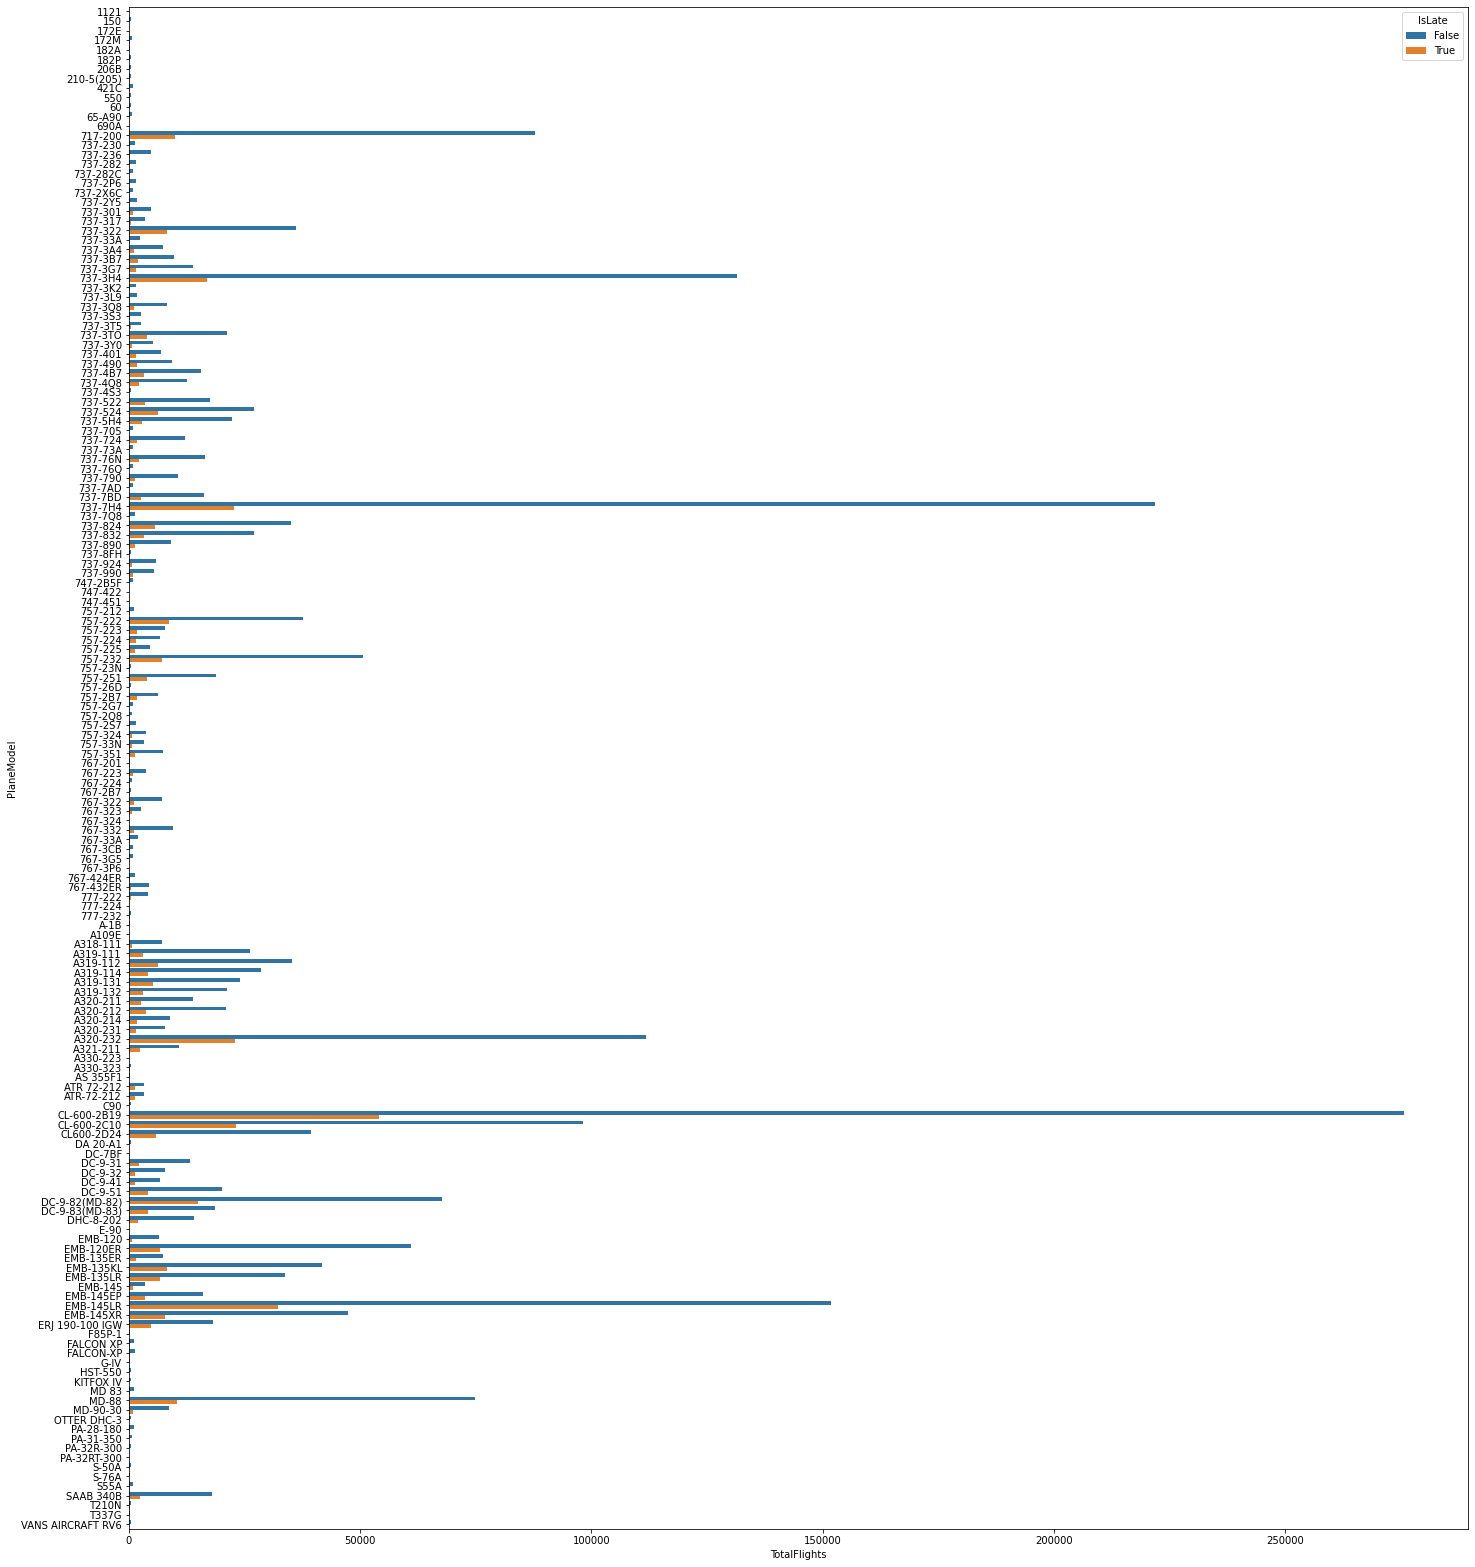

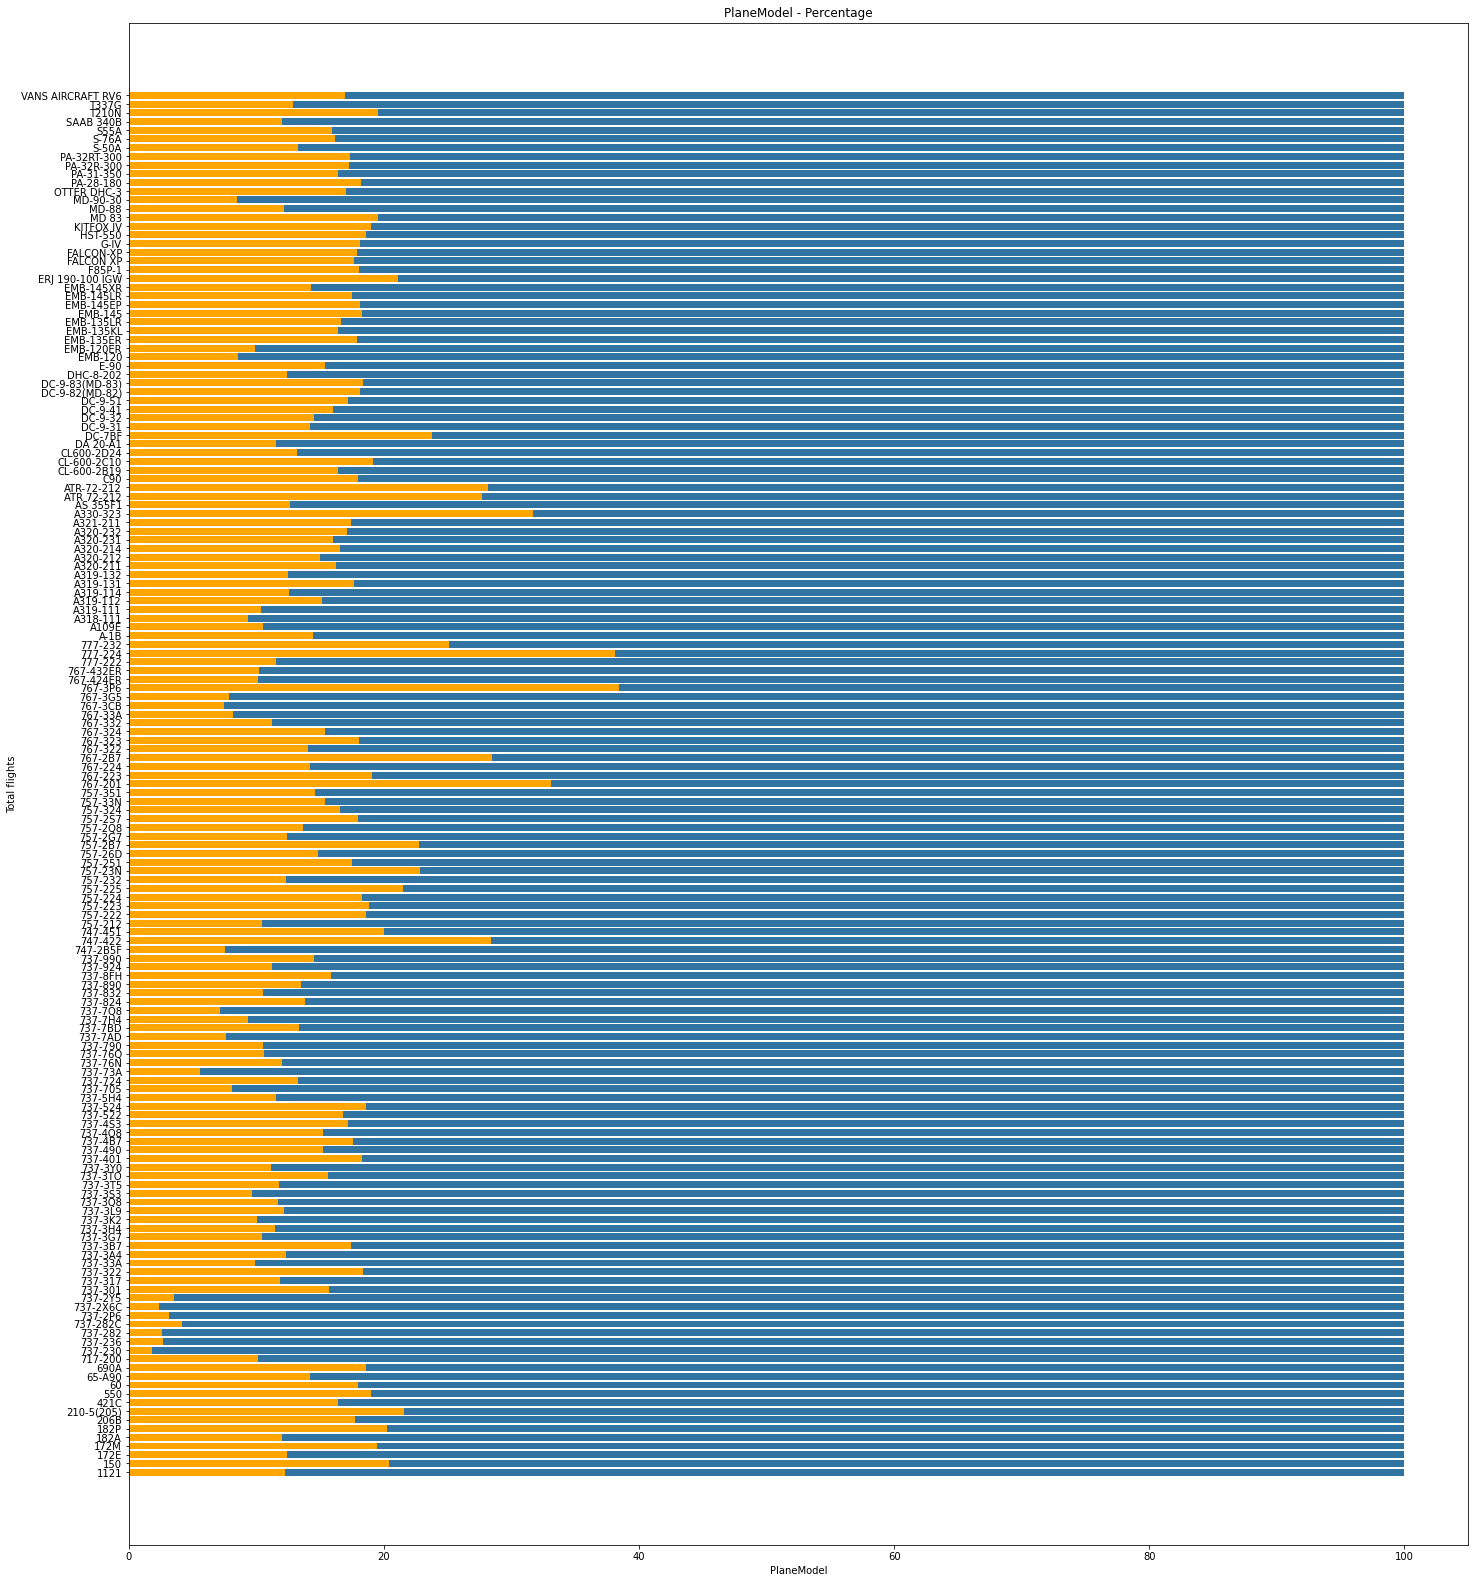

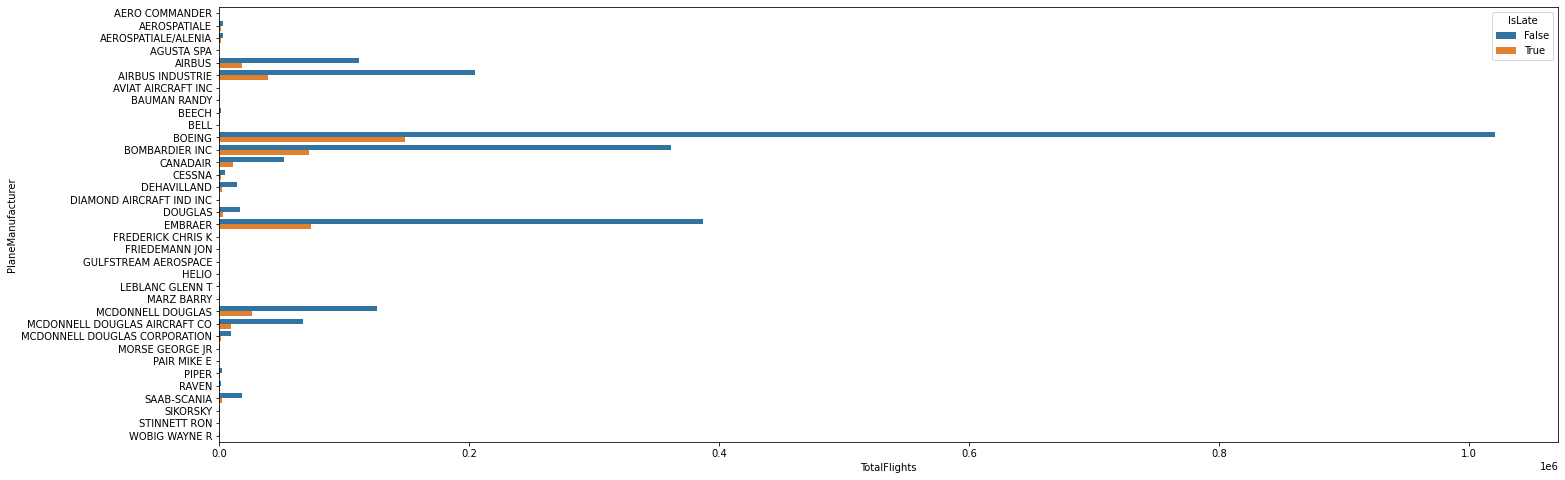

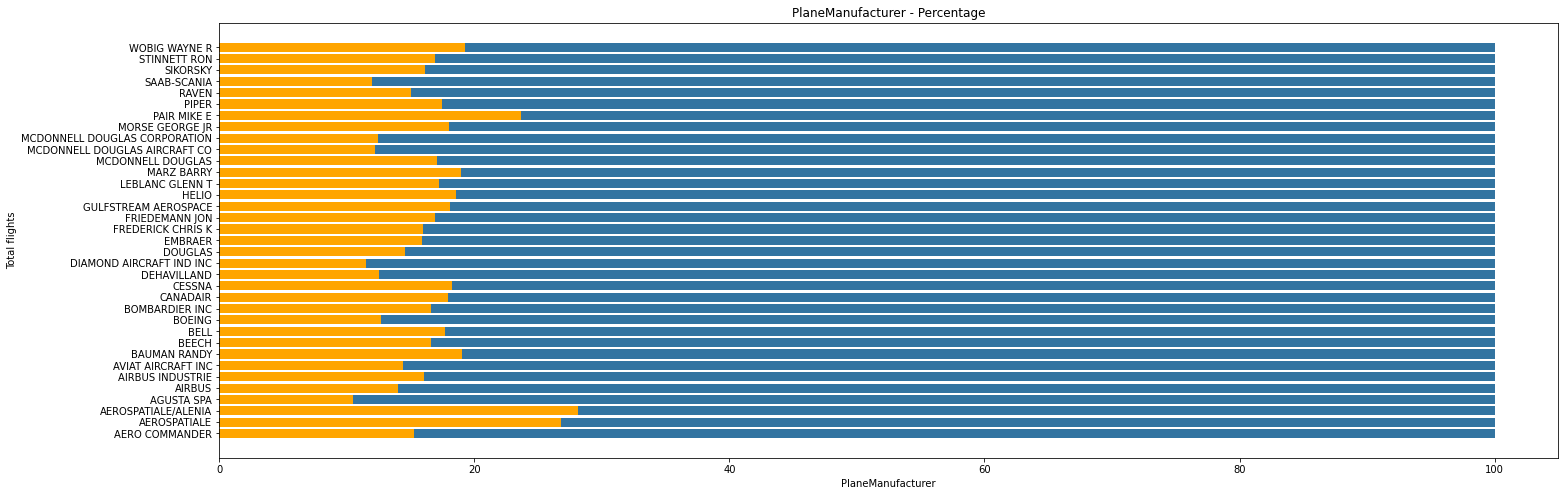

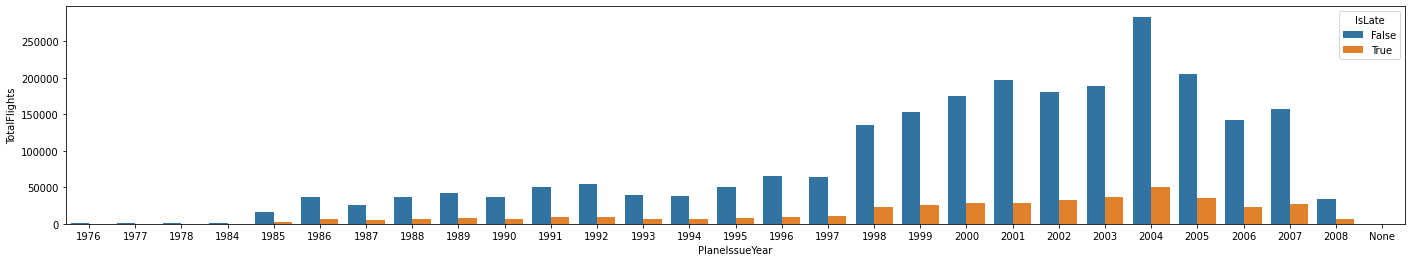

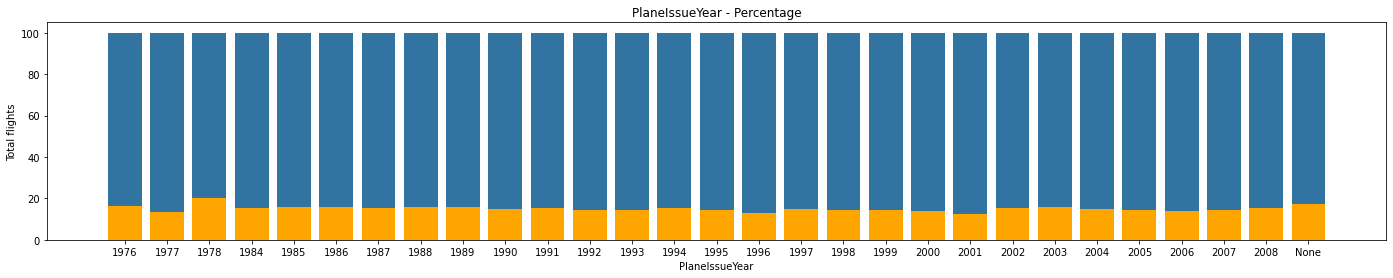

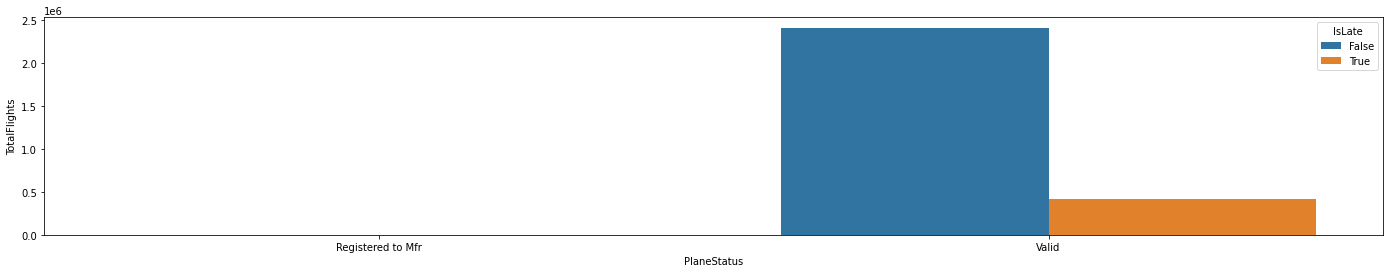

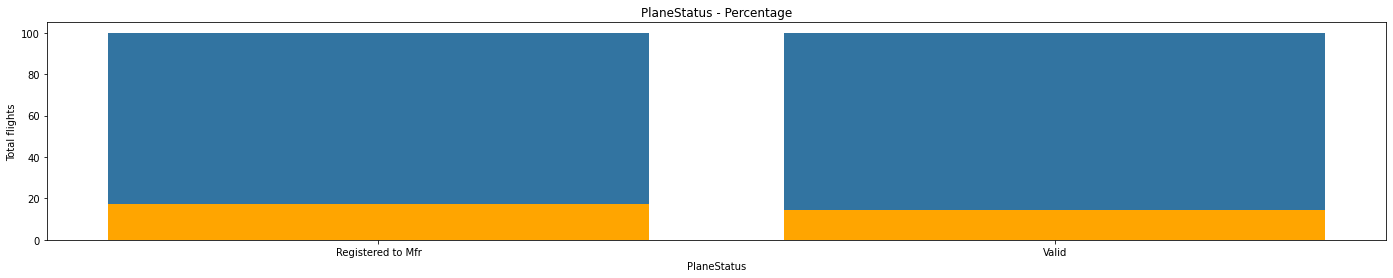

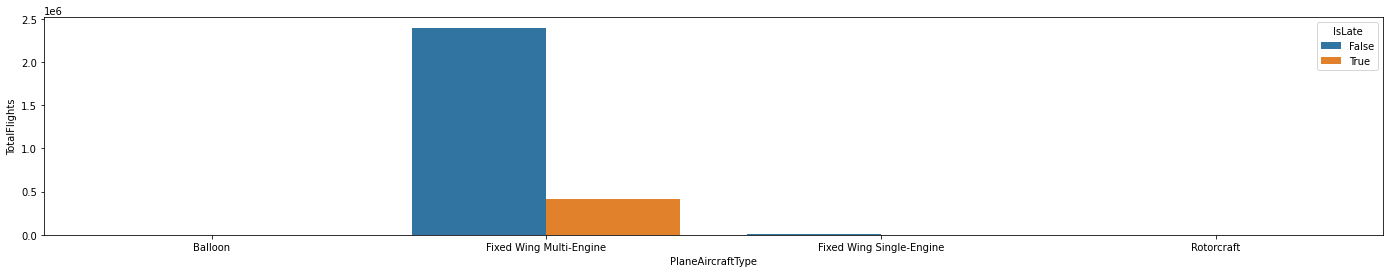

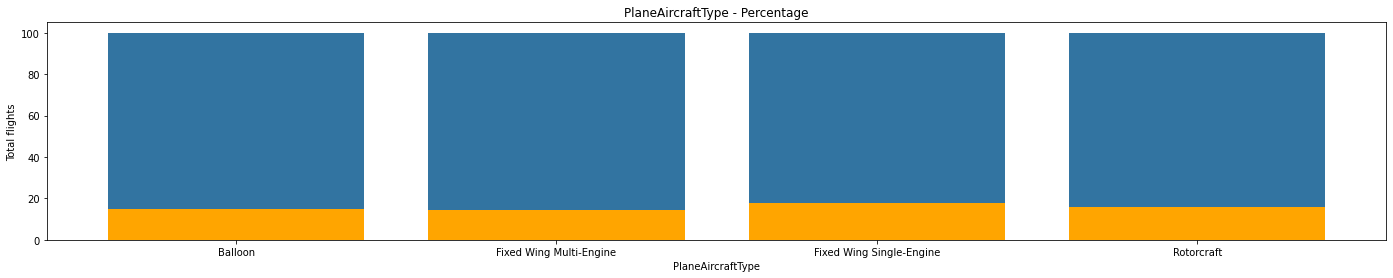

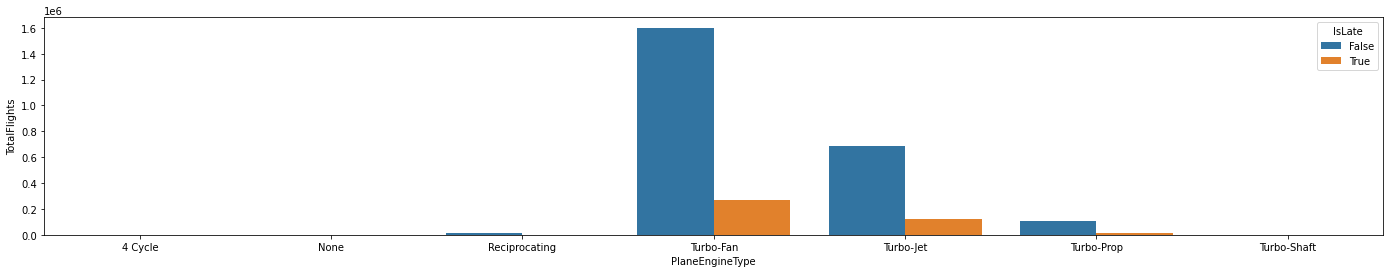

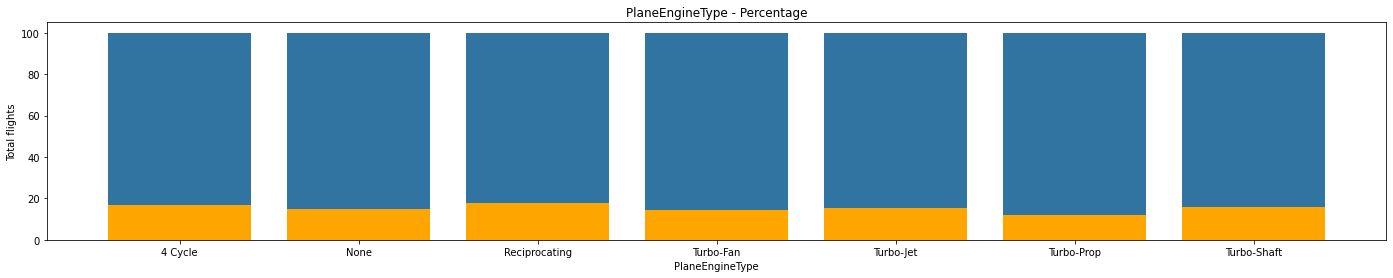

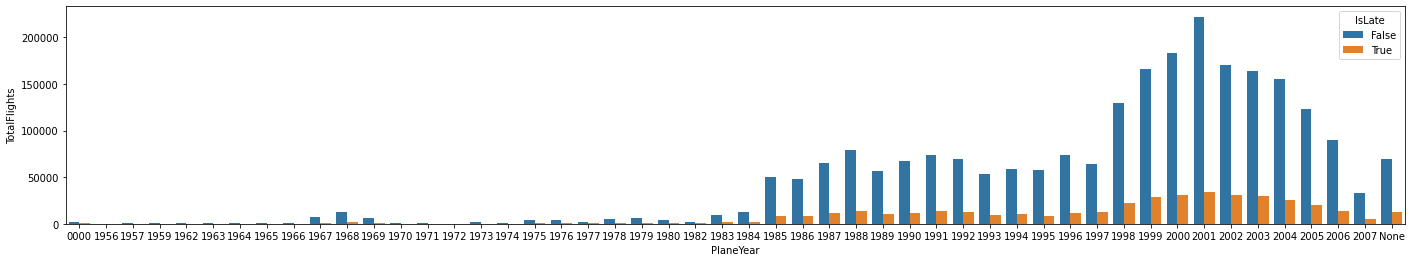

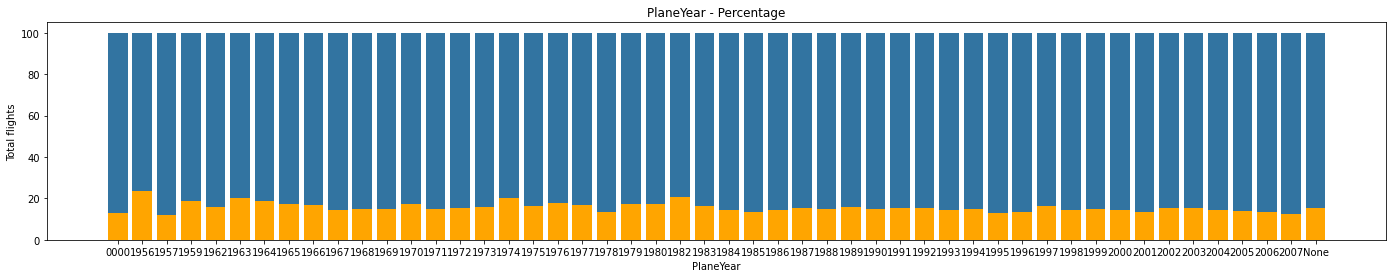

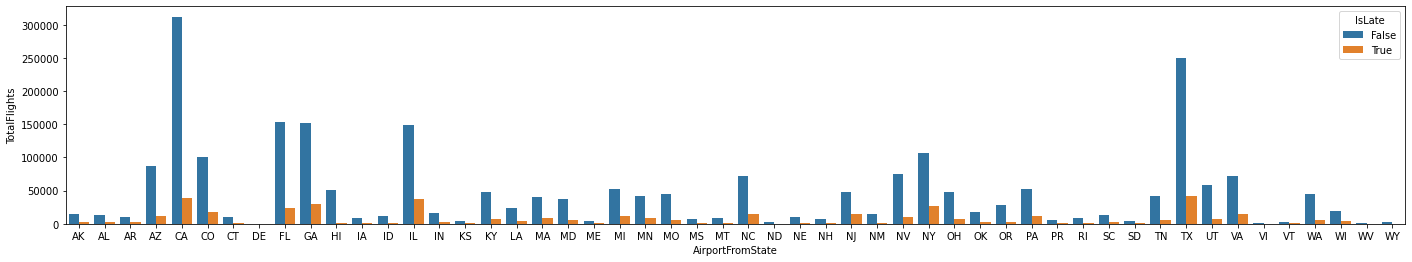

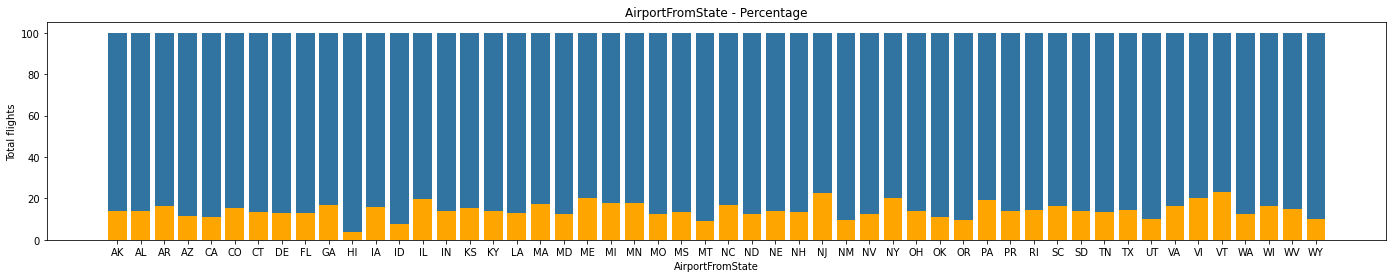

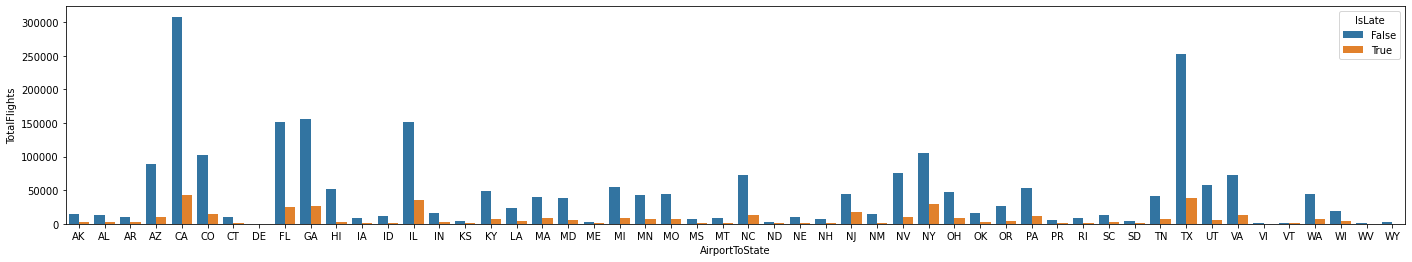

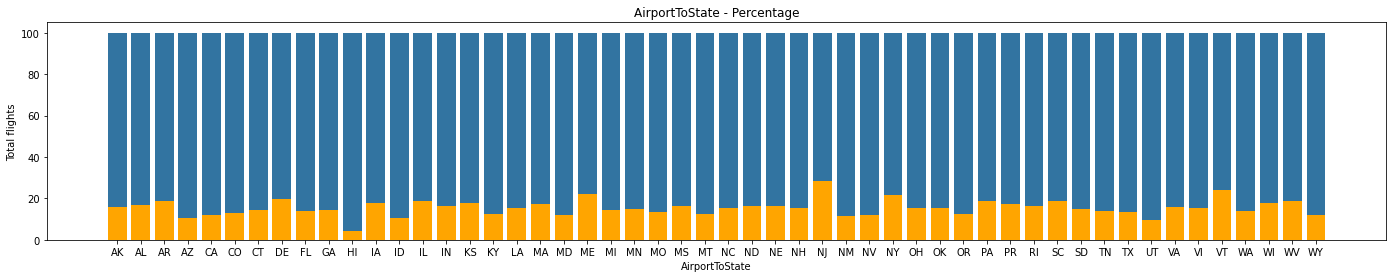

In [19]:
categorical_features = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime_Hour",
    "CRSArrTime_Hour",
    "CarrierDescription",
    "PlaneType",
    "PlaneModel",
    "PlaneManufacturer",
    "PlaneIssueYear",
    "PlaneStatus",
    "PlaneAircraftType",
    "PlaneEngineType",
    "PlaneYear",
    "AirportFromState",
    "AirportToState",
]
barh_columns = [
    "PlaneModel",
    "PlaneManufacturer",
    "CarrierDescription"
]

for column in categorical_features:
    visualize, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column)
    
    display(HTML(f"<h4>{column}</h4>"))

    # show IsLate percentage
    
    
    if column in barh_columns:
        height = 8 if column != "PlaneModel" else 28
        
        plt.figure(figsize=(24, height))
        sns.barplot(x="TotalFlights", hue="IsLate", y=column, data=visualize);
        plt.show()
        
        plt.figure(figsize=(24, height))
        plt.barh(column_values, is_late_percentage, color="orange")
        plt.barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    else:
        plt.figure(figsize=(24, 4))
        sns.barplot(x=column, hue="IsLate", y="TotalFlights", data=visualize);
        plt.show()
    
        plt.figure(figsize=(24, 4))
        plt.bar(column_values, is_late_percentage, color="orange")
        plt.bar(column_values, is_not_late_percentage, bottom=is_late_percentage, color="#3274a1")
        
    plt.xlabel(column)
    plt.ylabel("Total flights")
    plt.title(f"{column} - Percentage")
    plt.show()

From the visualized data, we can see that PlaneModel, DayofMonth, CRSDepTime_Hour, CRSArrTime_Hour, Month (4 months), CarrierDescription, PlaneManufacturer, AirportFromState, AirportToState have significant impact to the lateness of Flights.

In contrast, DayOfWeek, PlaneType, PlaneIssueYear, PlaneStatus, AircraftType don't show any promising influence to the lateness

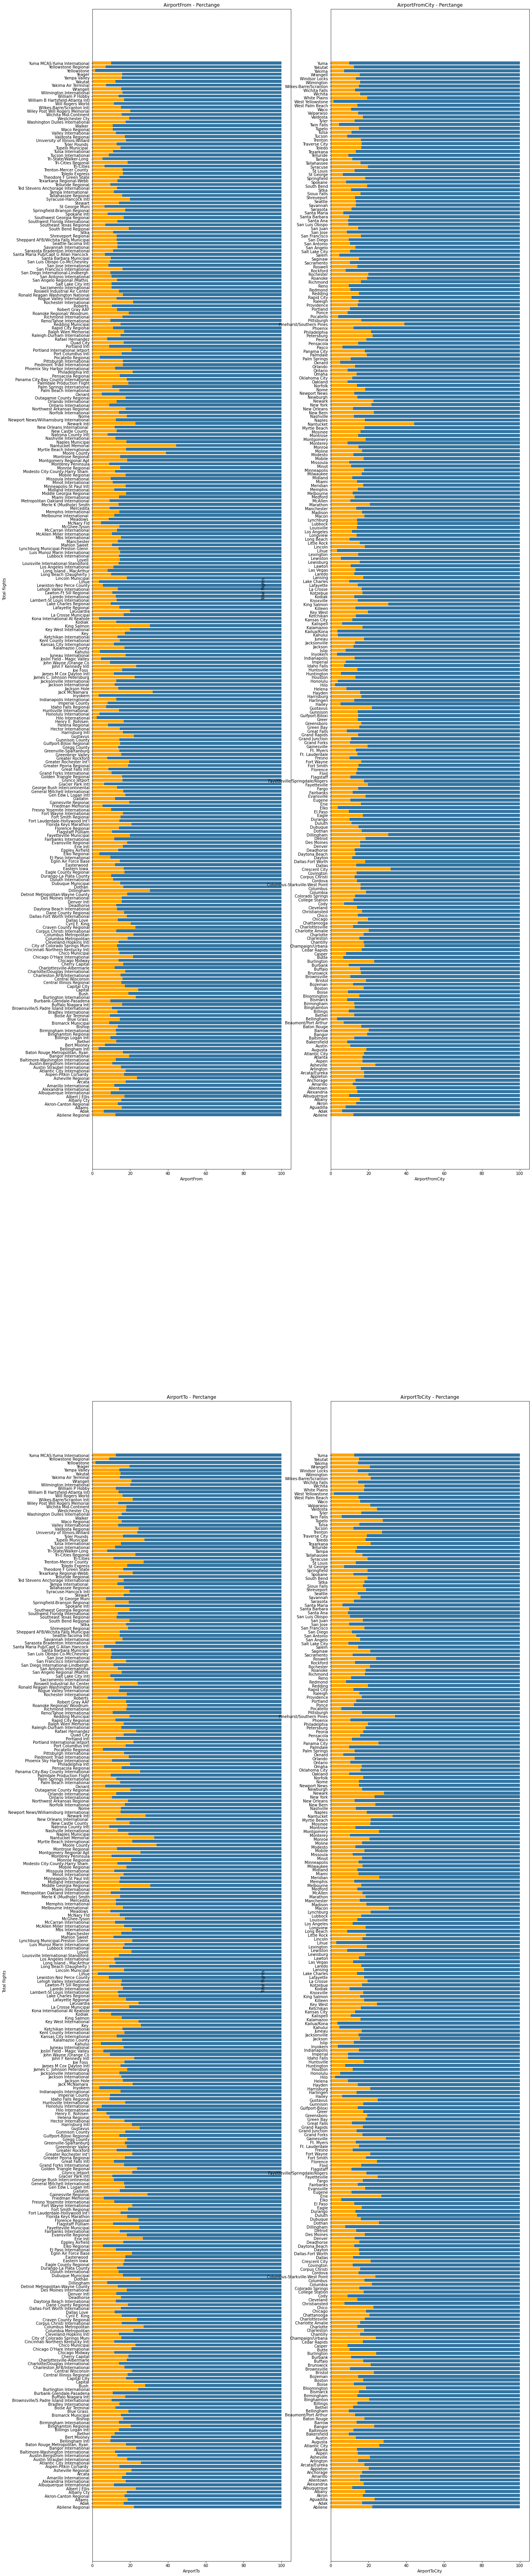

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(20, 120))
columns = [["AirportFrom", "AirportFromCity"], ["AirportTo", "AirportToCity"]]

for index, (column1, column2) in enumerate(columns):
    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column1)

    ax[index][0].barh(column_values, is_late_percentage, color="orange")
    ax[index][0].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][0].set_xlabel(column1)
    ax[index][0].set_ylabel("Total flights")
    ax[index][0].set_title(f"{column1} - Perctange")

    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column2)
    ax[index][1].barh(column_values, is_late_percentage, color="orange")
    ax[index][1].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][1].set_xlabel(column2)
    ax[index][1].set_ylabel("Total flights")
    ax[index][1].set_title(f"{column2} - Perctange")

plt.show()

<!--  "Origin", "Dest",  -->
According to the data, the late percentage is higher in the summer and winter season (by month) and in the night time. The DayOfWeek doesn't seem to have any impact on the lateness. Furthermore, DayOfMonth also doesn't show a clear effect on the lateness.

The most significant feature here is OpUniqueCarier, the late flights varies depending on this feature, because obviously there are some carriers most of the times depart in incorrected timing.

Besides, origin and dest also contribute to the lateness. Because there are bad and good conditioning airports, large and small area, easily for flights to depart and land, ...

### Hypothesis Testing

The null hypothesis for chi2 test is that "two categorical variables are independent". So a higher value of chi2 statistic means "two categorical variables are dependent" and MORE USEFUL for classification. [link](https://stackoverflow.com/a/51697444)



In [39]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [125]:
dropping_columns = [
    "DayofMonth",
    "DayOfWeek",
    "PlaneType",
    "PlaneStatus",
    "FlightNum",
    "PlaneAircraftType",
    "PlaneEngineType",
    # test random forest
    "PlaneModel",
    # PlaneYear and PlaneIssueYear also have plenty values whcih doesn't show a significant difference
    "PlaneYear",
    "PlaneIssueYear",
]

In [131]:
for dropping_column in dropping_columns:
    table = df.groupby([dropping_column, "IsLate"]).size()
    table_values = table.values
    removed_indices = []
    
    for index, (key, values) in enumerate(table.items()):
        if (index == 0 and table.keys()[index + 1][0] != key[0]) or \
           (table.keys()[index - 1][0] != key[0] and table.keys()[index + 1][0] != key[0]) or \
           (index == len(table_values) - 1 and table.keys()[index - 1][0] != key[0]):
            removed_indices.append(index)

    for index in sorted(removed_indices, reverse=True):
        table_values = np.delete(table_values, index)

    table_len = len(table_values)
    table_values = table_values.reshape((table_len // 2, 2))
    stat, p, dof, expected = chi2_contingency(table_values)
    # show 31 days in every month to check when the demands increase
    # show the lateness also
    # stats.chi2.ppf(df.groupby(["DayofMonth", "IsLate"]).size().values.reshape((31, 2)))
    prob = 0.95
    critical = chi2.ppf(prob, dof)

    if abs(stat) >= critical:
        print(f"{dropping_column}: Dependent (reject H0)")
    else:
        print(f"{dropping_column}: Independent (fail to reject H0)")

DayofMonth: Dependent (reject H0)
DayOfWeek: Dependent (reject H0)
PlaneType: Dependent (reject H0)
PlaneStatus: Independent (fail to reject H0)
FlightNum: Dependent (reject H0)
PlaneAircraftType: Dependent (reject H0)
PlaneEngineType: Dependent (reject H0)
PlaneModel: Dependent (reject H0)
PlaneYear: Dependent (reject H0)
PlaneIssueYear: Dependent (reject H0)


### Filter noise & Feature engineering

In [132]:
from scipy import stats

# due to having too manu unique values, we drop AirportFrom, AirportFromCity, AirportTo, AirportToCity, and FlightNum
# similarly, DayOfWeek, PlaneType, PlaneIssueYear, PlaneStatus, PlaneEngineType, and PlaneAircraftType don't show any relation to the lateness
df = df.drop([
    "DayofMonth",
    "DayOfWeek",
    "PlaneType",
#     "PlaneStatus",
    "FlightNum",
    "PlaneAircraftType",
    "PlaneEngineType",
    "AirportFrom",
    "AirportFromCity",
    "AirportTo",
    "AirportToCity",
    # test random forest
    "PlaneModel",
    # PlaneYear and PlaneIssueYear also have plenty values whcih doesn't show a significant difference
    "PlaneYear",
    "PlaneIssueYear",
], axis=1)

# Q1,Q3 = np.percentile(sorted(df['Price']),[25,75])
# IQR = Q3 - Q1
# upperlim = Q3 + 1.5*IQR
# lowerlim = max(Q1 - 1.5*IQR,0)

# calculate z-score to filter noise
for feature in numerical_features:
    z_scores = np.abs(stats.zscore(df[feature]))
    df = df[z_scores <= 3]

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2553024 entries, 733327 to 5445013
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Month               object 
 1   CRSElapsedTime      float64
 2   Distance            int64  
 3   TaxiIn              int64  
 4   TaxiOut             int64  
 5   CarrierDescription  object 
 6   PlaneManufacturer   object 
 7   PlaneStatus         object 
 8   AirportFromState    object 
 9   AirportFromLat      float64
 10  AirportFromLong     float64
 11  AirportToState      object 
 12  AirportToLat        float64
 13  AirportToLong       float64
 14  IsLate              bool   
 15  CRSDepTime_Hour     object 
 16  CRSArrTime_Hour     object 
dtypes: bool(1), float64(5), int64(3), object(8)
memory usage: 333.6+ MB


In [134]:
dummy_columns = ["PlaneStatus", "CarrierDescription", "PlaneManufacturer", "AirportFromState", "AirportToState"]

for column in dummy_columns:
    df = df.join(pd.get_dummies(df[column], column, drop_first=True, dtype=bool))
    
df = df.drop(dummy_columns, axis=1)

In [135]:
# feature engineering
# I see the abnormal from these hours and months, so I decided to create the new features for them
# calculate IG of CRSElapsedTime and Distance
df["IsArrTimeNoonOrEvening"] = df["CRSArrTime_Hour"].isin([str(i) for i in range(13, 24)])
df["IsUnusualCRSDepHour"] = df["CRSDepTime_Hour"].isin(["16", "17", "18", "19", "20", "21", "22", "23", "00", "01", "02", "03"])
df["IsSummerOrWinter"] = df["Month"].isin(["12", "01", "02", "06", "07", "08"])

df = df.drop(["CRSArrTime_Hour", "CRSDepTime_Hour", "Month"], axis=1)

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2553024 entries, 733327 to 5445013
Columns: 158 entries, CRSElapsedTime to IsSummerOrWinter
dtypes: bool(150), float64(5), int64(3)
memory usage: 620.5 MB


In [137]:
from sklearn.model_selection import train_test_split

X = df.drop(["IsLate"], axis=1)
y = df["IsLate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# because the below features don't illustrate the bell shape --> use min_max_scaling
min_max_scaling_columns = numerical_features

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[min_max_scaling_columns])

X_train[min_max_scaling_columns] = min_max_scaler.transform(X_train[min_max_scaling_columns])
X_test[min_max_scaling_columns] = min_max_scaler.transform(X_test[min_max_scaling_columns])

In [138]:
del df, X, y

### Train models

#### ROC curve
__Definition:__ a graph showing the performance of a classification model at all classification thresholds. Plot two params:
- True Positive Rate: $ TPR = \frac{TP}{TP + FN} $ (denominator is positivity **True Positive** -> **Positive**, mẫu số là tổng số dương tính)
- False Positive Rate: $ FPR = \frac{FP}{FP + TN} $ (denominator is negativity, **False Positive** -> **Negative**, mẫu số là tổng số âm tính)

__Reference:__ https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

This graph doesn't show any promising result when classifying late or not late flights.

In [139]:
def show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test,  y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"data 1, auc={auc}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()
    
    P = metrics.precision_score(y_test, y_pred)
    R = metrics.recall_score(y_test, y_pred)
    F = 2 * ((P * R) / (P + R))
    print("Precision:", P)
    print("Recall:", R)
    print("F1 score:", F)

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn import metrics
import time

In [141]:
training_columns = X_train.columns

In [144]:
def train_n_visualize_model(modelClass, X_train, y_train, X_test, y_test):
    start = time.time()

    model = modelClass()
    model.fit(X_train, y_train);

    print("Total time to train model:", time.time() - start)

    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test).max(axis=1)

    print("Test score:", test_score)
    print("Precision matrix:")
    print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))
    
    show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob)
    
    importances = None
    
    if isinstance(model, LogisticRegression):
        if type(X_train) != np.ndarray:
            importances = pd.DataFrame({"Column": training_columns, "Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
        else:
            total_features = X_train_pca.shape[1]

            importances = pd.DataFrame({"Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
    
    return model, y_pred_prob, importances

Due to the extremely imbalanced dataset, we can't use accuracy as a suitable score.

Rather, we use recall because it's more appropriate in this situtation, because it actually measures rate of the predicted late flights among the ground-truth late flights.

#### Logistic Regression

Total time to train model: 49.1783127784729
Test score: 0.8695899451003986
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    553960
     class 1       0.58      0.04      0.08     84296

    accuracy                           0.87    638256
   macro avg       0.73      0.52      0.51    638256
weighted avg       0.83      0.87      0.82    638256



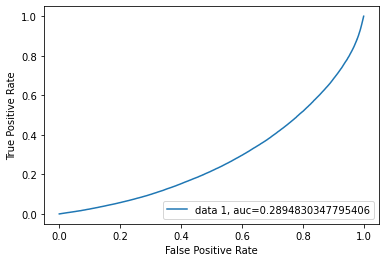

Precision: 0.5816279427604247
Recall: 0.044841985384834394
F1 score: 0.08326449694366429


,Column,Amount
3,TaxiOut,3.005547
1,Distance,1.485931
4,AirportFromLat,0.957914
134,AirportToState_NJ,0.950542
2,TaxiIn,0.717292
...,...,...
93,AirportFromState_OR,-0.664624
103,AirportFromState_WA,-0.823900
100,AirportFromState_UT,-0.830868
8,PlaneStatus_Valid,-1.980520


In [145]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train, y_train, X_test, y_test)
importances

As we can see, LogisticRegression performs not so well in this dataset. I guess because the dataset doesn't have linear trending features to feed to the model.

In [146]:
del model1
del _

#### Decision Tree

Total time to train model: 64.16346645355225
Test score: 0.8011189867388634
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.89      0.89    553960
     class 1       0.24      0.24      0.24     84296

    accuracy                           0.80    638256
   macro avg       0.56      0.56      0.56    638256
weighted avg       0.80      0.80      0.80    638256



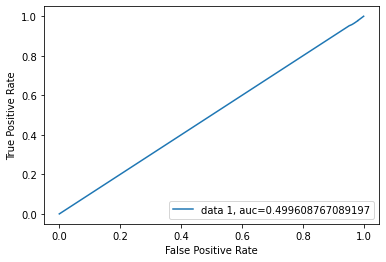

Precision: 0.24199189205542446
Recall: 0.23722359305305116
F1 score: 0.23958401974468493


In [147]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test)
importances

The recall is higher, we could predict 24% of late flight correctly

In [148]:
del model2
del _

#### Naive Bayes

Total time to train model: 15.57227349281311
Test score: 0.7120074076859442
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.76      0.82    553960
     class 1       0.20      0.38      0.26     84296

    accuracy                           0.71    638256
   macro avg       0.54      0.57      0.54    638256
weighted avg       0.80      0.71      0.75    638256



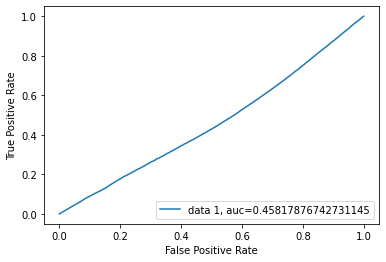

Precision: 0.19684036726313417
Recall: 0.3832684824902724
F1 score: 0.26009845871456233


In [149]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train, y_train, X_test, y_test)
importances

In [150]:
del model3
del _

#### Support Vector Machine

In [151]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 495.14287543296814
Test score: 0.8470315986062019
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.92    553960
     class 1       0.33      0.15      0.21     84296

    accuracy                           0.85    638256
   macro avg       0.60      0.55      0.56    638256
weighted avg       0.81      0.85      0.82    638256



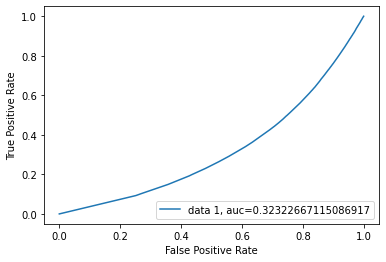

Precision: 0.3288943627639648
Recall: 0.15205940969915535
F1 score: 0.20796794003358507


In [152]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train, y_train, X_test, y_test)
importances

In [153]:
del model5
del _

## PCA

In [154]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

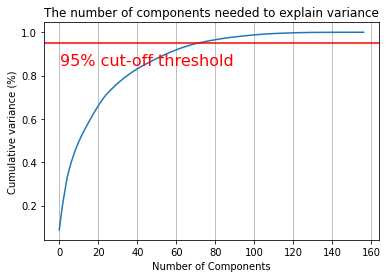

In [155]:
fig, ax = plt.subplots()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x')
plt.show()

In [156]:
pca = PCA(n_components=70).fit(X_train)

In [157]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [158]:
# import sys

# local_vars = list(locals().items())
# for var, obj in local_vars:
#     print(var, sys.getsizeof(obj))

#### Logistic Regression

Total time to train model: 7.060124397277832
Test score: 0.8694254343084906
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    553960
     class 1       0.58      0.04      0.08     84296

    accuracy                           0.87    638256
   macro avg       0.73      0.52      0.50    638256
weighted avg       0.83      0.87      0.82    638256



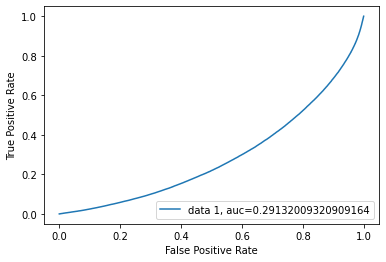

Precision: 0.5799063858241391
Recall: 0.04115260510581759
F1 score: 0.07685150313476151


,Amount
60,1.108359
61,1.086968
52,0.954774
62,0.954544
64,0.833543
...,...
49,-0.560142
55,-0.577832
1,-0.889636
57,-1.021889


In [159]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train_pca, y_train, X_test_pca, y_test)
importances

In [160]:
del model1
del _

#### Decision Tree

Total time to train model: 492.55373072624207
Test score: 0.8005032463462937
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.89      0.89    553960
     class 1       0.24      0.23      0.23     84296

    accuracy                           0.80    638256
   macro avg       0.56      0.56      0.56    638256
weighted avg       0.80      0.80      0.80    638256



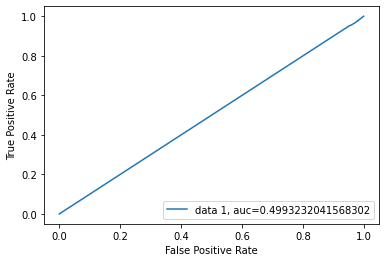

Precision: 0.23757195823982827
Recall: 0.23107858024105532
F1 score: 0.23428028480708168


In [161]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train_pca, y_train, X_test_pca, y_test)
importances

All of the scores decrease slightly when using PCA, around 0.00x

In [162]:
del model2
del _

#### Naive Bayes

Total time to train model: 1.3258411884307861
Test score: 0.8152935499235416
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.90      0.89    553960
     class 1       0.27      0.24      0.25     84296

    accuracy                           0.82    638256
   macro avg       0.58      0.57      0.57    638256
weighted avg       0.80      0.82      0.81    638256



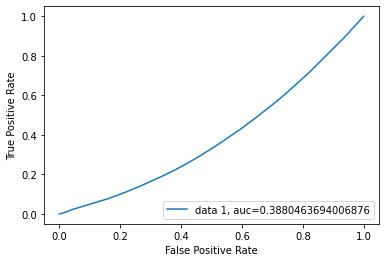

Precision: 0.27156884077680465
Recall: 0.23689143019834868
F1 score: 0.2530476214613377


In [163]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train_pca, y_train, X_test_pca, y_test)
importances

Naive Bayes significantly decreases the recall score of late flight and increase not-late flight's recall

In [164]:
del model3
del _

#### Support Vector Machine

In [ ]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 3134.651504278183
Test score: 0.8458570739076202
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.91    553455
     class 1       0.32      0.14      0.20     84693

    accuracy                           0.85    638148
   macro avg       0.60      0.55      0.56    638148
weighted avg       0.80      0.85      0.82    638148



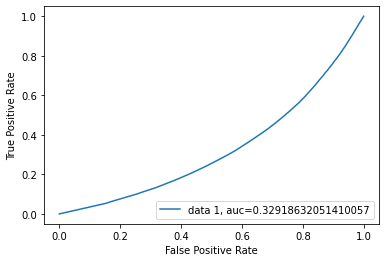

Precision: 0.31925974884335756
Recall: 0.14258557377823433
F1 score: 0.1971302176006791


In [56]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train_pca, y_train, X_test_pca, y_test)
importances

In [57]:
del model5
del _

## SelectKBest

In [58]:
from sklearn.feature_selection import SelectKBest

selectKBest = SelectKBest(k=20)
selectKBest.fit(X_train, y_train)
X_train_kbest = selectKBest.transform(X_train)
X_test_kbest = selectKBest.transform(X_test)

print("New shape after transforming: ", X_train_kbest.shape)

New shape after transforming:  (1914443, 20)


In [72]:
selectKBest.pvalues_

array([1.37880286e-031, 2.43935406e-001, 0.00000000e+000, 0.00000000e+000,
       3.15145612e-219, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       5.98188184e-003, 1.04798422e-016, 5.08834875e-146, 1.18409373e-260,
       0.00000000e+000, 3.14977489e-024, 2.66513333e-006, 0.00000000e+000,
       1.29115494e-005, 8.72315607e-070, 1.05248998e-074, 3.03706073e-036,
       1.81841928e-009, 2.03683448e-090, 0.00000000e+000, 1.85021585e-027,
       9.38146688e-241, 4.55935852e-102, 4.00285628e-136, 7.95802793e-001,
       7.85444633e-017, 1.36302933e-036, 1.04391058e-001, 2.02385172e-001,
       6.50533945e-002, 9.15793706e-001, 0.00000000e+000, 1.07953257e-300,
       1.79170288e-047, 5.16315763e-005, 3.65619733e-005, 3.46134224e-002,
       1.78420999e-001, 1.38678402e-051, 4.35724519e-001, 1.25199518e-001,
       7.39513793e-004, 9.58761108e-004, 1.75467582e-001, 1.03764087e-002,
       2.68517467e-080, 1.76704209e-100, 1.10851909e-022, 2.04945380e-001,
       3.80433419e-005, 6

#### Logistic Regression

Total time to train model: 3.9925131797790527
Test score: 0.868408268928211
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    553455
     class 1       0.57      0.04      0.07     84693

    accuracy                           0.87    638148
   macro avg       0.72      0.52      0.50    638148
weighted avg       0.83      0.87      0.81    638148



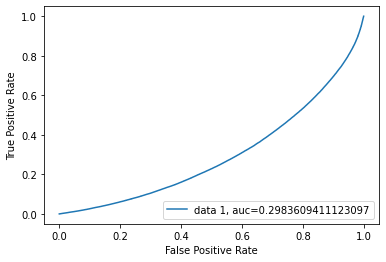

Precision: 0.5682509505703423
Recall: 0.035292172906851806
F1 score: 0.06645692750658677


,Amount
1,2.754987
0,0.696285
17,0.694247
15,0.648253
6,0.551213
18,0.491123
19,0.436448
5,0.325928
9,0.278699
16,0.245612


In [59]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [60]:
del model1
del _

#### Decision Tree

Total time to train model: 11.025588750839233
Test score: 0.8100471990823446
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.90      0.89    553455
     class 1       0.24      0.20      0.22     84693

    accuracy                           0.81    638148
   macro avg       0.56      0.55      0.56    638148
weighted avg       0.80      0.81      0.80    638148



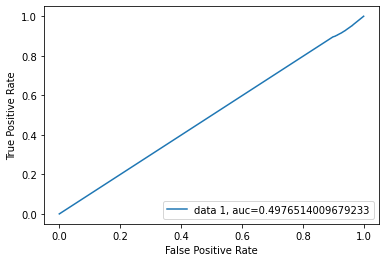

Precision: 0.24299525746210895
Recall: 0.20387753415276352
F1 score: 0.2217242796240177


In [61]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train_kbest, y_train, X_test_kbest, y_test)
importances

All of the scores decrease slightly when using PCA, around 0.00x

In [62]:
del model2
del _

#### Naive Bayes

Total time to train model: 1.0513005256652832
Test score: 0.7837633276293273
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.86      0.87    553455
     class 1       0.24      0.30      0.27     84693

    accuracy                           0.78    638148
   macro avg       0.57      0.58      0.57    638148
weighted avg       0.80      0.78      0.79    638148



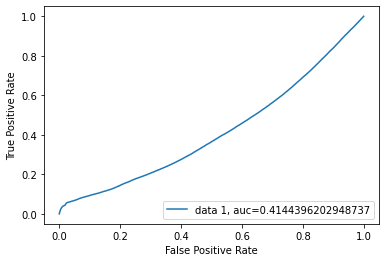

Precision: 0.24352780397667123
Recall: 0.2987732162044089
F1 score: 0.26833652352345455


In [63]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train_kbest, y_train, X_test_kbest, y_test)
importances

Naive Bayes significantly decreases the recall score of late flight and increase not-late flight's recall

In [64]:
del model3
del _

#### Support Vector Machine

In [65]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 218.8849391937256
Test score: 0.841925384080182
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.91    553455
     class 1       0.30      0.15      0.20     84693

    accuracy                           0.84    638148
   macro avg       0.59      0.55      0.56    638148
weighted avg       0.80      0.84      0.82    638148



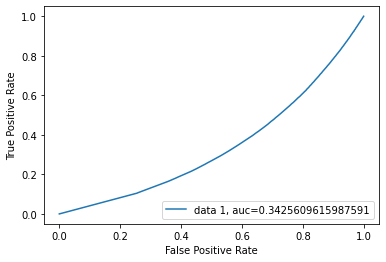

Precision: 0.3028508771929825
Recall: 0.1467535687719174
F1 score: 0.19770465987449595


In [66]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [67]:
del model5
del _

In [ ]:
selectKBest